In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import yfinance as yf
import numpy as np

import datetime as dt

In [2]:
# 시각화 관련 ##
import plotly_express as px
import plotly.figure_factory as ff
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')
import plotly.graph_objects as go

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
## plt.style.use("fivethirtyeight")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (10,6)

In [3]:
##절대경로 참조
import sys, os
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))

from library.quant_functions import anal_funcs, data_funcs

In [4]:
## 조건1. 판단기준 -> 1개월*12, 3개월*4, 6개월*2 평균, 12개월*1
## 조건2. 공격자산 중 하나라도 (-)진입시 수비자산 전환
## 조건3. 모든 포지션에서 판단기준값이 가장 높은 자산 투자
## 조건4. 월단위 리벨런싱

## Func

In [5]:
### 1개월 수익률, 3개월 수익률, 6개월 수익률의 가중평균 산출함수
def get_wapr(close):
    ## 월단위 데이터를 기준으로함
    ## get_signal()로 이어짐
    df_cls = close.copy()
    pr1 = np.log(df_cls/df_cls.shift(1))
    pr3 = np.log(df_cls/df_cls.shift(3))
    pr6 = np.log(df_cls/df_cls.shift(6))
    pr12 = np.log(df_cls/df_cls.shift(12))
    df_pr = pd.concat([pr1, pr3*(4/12), pr6*(2/12), pr12*(1/12)], axis = 1)
    mpr = df_pr.mean(axis=1)
    
    return mpr

def get_signal(df):
    ## 금리2% 1개월 무위험수익률 ## 향후 기준금리 데이터 반영 가능
    nrr = (1.02**(1/12))-1
    ## get_strategy_value()로 이어짐

    signal_df = df.copy()
    for cols in signal_df.columns:
        signal_df[cols] = get_wapr(signal_df[cols])
    signal_df = signal_df.dropna()

    atks= signal_df[signal_df.columns[:4]].T
    dfcs= signal_df[signal_df.columns[4:]].T
    
    ## 판단로직
    signal_df['diretion'] = 'bear'
    signal_df['diretion'][(signal_df[signal_df.columns[0]] > nrr)&(signal_df[signal_df.columns[1]] > nrr)&
                       (signal_df[signal_df.columns[2]] > nrr)&(signal_df[signal_df.columns[3]] > nrr)] = 'bull'

    optimal_ticker = []
    for i in range(len(signal_df)):
        if signal_df['diretion'][i] == 'bull':
            optimal_ticker.append(atks[atks[atks.columns[i]] == atks[atks.columns[i]].max()].index.values[0])
        elif signal_df['diretion'][i] == 'bear':
            optimal_ticker.append(dfcs[dfcs[dfcs.columns[i]] == dfcs[dfcs.columns[i]].max()].index.values[0])

    signal_df['signal'] = optimal_ticker
    ### 여기
    
    new_df = df.copy()
    new_df['signal'] = signal_df['signal']
    new_df['prev'] = new_df['signal'].shift(1)
    
    new_df['change'] = 0
    new_df['change'][new_df['signal'] != new_df['prev']] = 1
    new_df = new_df.dropna()
    
    return new_df, signal_df



def get_strategy_value(df):
    new_df, _ = get_signal(df)
    
    ## 시그널발생시 자산 교환 비율 산출
    new_df['exchange_rate'] = 1.0
    for i in range(len(new_df)):
        if (new_df['change'][i] == 1)&(type(new_df['prev'][i]) == str):
            new_df['exchange_rate'][i] = new_df[new_df['prev'][i]][i]/new_df[new_df['signal'][i]][i]         
    ## 누적 교환비 산출
    new_df['cum_exchange_rate'] = new_df['exchange_rate']
    for i in range(len(new_df)):
        new_df['cum_exchange_rate'][i] = new_df['exchange_rate'][:i+1].product()
    ## 자산추이
    new_df['strategy'] = 1.0
    for i in range(len(new_df)):
        new_df['strategy'][i] = new_df[new_df['signal'][i]][i]*new_df['cum_exchange_rate'][i]
        
    result = new_df.drop(columns=['change', 'exchange_rate', 'cum_exchange_rate'])
        
    return result

## Proc

In [6]:
## X3 VAA전략 ## 확정전
## df = get_merged_df('TQQQ', 'UPRO', 'EURL', 'EDC', 'TMF', 'TYD', 'BNKU')
## df['CASH'] = 1 ## SHY 대용 CASH
df = data_funcs.get_merged_df('SPY', 'QQQ', 'VEA', 'VWO', 'TLT', 'IEF', 'SHY')
df = df[['SPY', 'QQQ', 'VEA', 'VWO', 'TLT', 'IEF', 'SHY']]

dataset = df.dropna()
## dataset = dataset[dataset.index >= '2010-10-01']

[*********************100%***********************]  7 of 7 completed


In [7]:
df = dataset.resample('M').last()
df = df[:].copy()

In [8]:
strategy_df_result = get_strategy_value(df)

result_df = strategy_df_result.copy()
temp = result_df[['IEF', 'QQQ', 'SHY', 'SPY', 'TLT', 'VEA', 'VWO', 'strategy']]
result_df[['IEF', 'QQQ', 'SHY', 'SPY', 'TLT', 'VEA', 'VWO', 'strategy']] = temp/np.array(temp)[0]

_, signal_df = get_signal(df)

## Report

In [9]:
## 기하수익률
np.log(strategy_df_result[strategy_df_result.columns[:-3]]/strategy_df_result[strategy_df_result.columns[:-3]].shift(1)).tail(6)

,SPY,QQQ,VEA,VWO,TLT,IEF,SHY
Date,,,,,,,
2022-12-31,-0.063937,-0.096852,-0.033735,-0.038747,-0.031344,-0.018926,-0.003075
2023-01-31,0.060989,0.101138,0.086455,0.080082,0.073656,0.035185,0.007732
2023-02-28,-0.025464,-0.003604,-0.035365,-0.068858,-0.052291,-0.035394,-0.009952
2023-03-31,0.032598,0.089141,0.022387,0.024557,0.044798,0.034486,0.014343
2023-04-30,0.015849,0.005066,0.026004,-0.003968,0.000846,0.006135,0.000243
2023-05-31,0.006853,0.045691,0.001724,-0.002239,-0.055226,-0.023127,-0.005246


In [10]:
## 최근 상대 수준
strategy_df_result.tail(6)

,SPY,QQQ,VEA,VWO,TLT,IEF,SHY,signal,prev,strategy
Date,,,,,,,,,,
2022-12-31,382.429993,266.279999,41.970001,38.980000,99.559998,95.779999,81.169998,SHY,VEA,332.085704
2023-01-31,406.480011,294.619995,45.759998,42.230000,107.169998,99.209999,81.800003,VEA,SHY,334.663203
2023-02-28,396.260010,293.559998,44.169998,39.419998,101.709999,95.760002,80.989998,SHY,VEA,323.034825
2023-03-31,409.390015,320.929993,45.169998,40.400002,106.370003,99.120003,82.160004,QQQ,SHY,327.701483
2023-04-30,415.929993,322.559998,46.360001,40.240002,106.459999,99.730003,82.180000,IEF,QQQ,329.365881
2023-05-31,418.790009,337.640015,46.439999,40.150002,100.739998,97.449997,81.750000,SHY,IEF,321.835987


In [11]:
## 시그널 근거
signal_df.tail(6)

,SPY,QQQ,VEA,VWO,TLT,IEF,SHY,diretion,signal
Date,,,,,,,,,
2022-12-31,-0.014238,-0.035019,0.000617,-0.011907,-0.024467,-0.011468,-0.002726,bear,SHY
2023-01-31,0.016834,0.022939,0.037026,0.032132,0.017762,0.007866,0.001333,bull,VEA
2023-02-28,-0.010641,-0.005119,-0.005380,-0.025302,-0.024512,-0.015924,-0.004491,bear,SHY
2023-03-31,0.017465,0.042927,0.019481,0.010599,0.013768,0.011130,0.004781,bull,QQQ
2023-04-30,0.009164,0.015629,0.015979,-0.001328,0.001520,0.003620,0.000868,bear,IEF
2023-05-31,0.007735,0.030834,0.007840,-0.001149,-0.018459,-0.005611,-0.000768,bear,SHY


In [12]:
test_dfs = [result_df.reset_index().shift(i).set_index('Date')[-(len(result_df)+1 - int(len(result_df)/10)):]
            for i in range(int(len(result_df)/10))]

In [13]:
CAGR = np.mean([anal_funcs.get_ACI_CAGR(test_dfs[i]['strategy']) for i in range(len(test_dfs))])
print(f'적립식 수행시, 누적 시뮬레이션 수익률: {CAGR.round(2)}%')

적립식 수행시, 누적 시뮬레이션 수익률: 99.37%


In [14]:
RPP = np.mean([anal_funcs.get_ACI_RPP(test_dfs[i]['strategy']) for i in range(len(test_dfs))])
print(f'적립식 수행시, 월평균 시뮬레이션 수익률: {RPP.round(2)}%')

적립식 수행시, 월평균 시뮬레이션 수익률: 0.8%


In [15]:
## 연수익률
anal_funcs.get_YTD_report(result_df, 'a')

,SPY,QQQ,VEA,VWO,TLT,IEF,SHY,strategy
Date,,,,,,,,
2008,-38.28,-41.94,-42.68,-54.80,28.28,13.24,3.01,6.44
2009,23.49,53.83,24.50,73.95,-24.68,-10.08,-2.01,17.75
2010,12.84,19.04,5.70,17.44,4.71,5.89,1.23,-5.91
2011,-0.20,2.52,-15.27,-20.64,28.82,12.52,0.62,18.34
2012,13.47,16.66,15.02,16.54,-0.06,1.82,-0.09,15.03
2013,29.69,35.05,18.31,-7.61,-15.94,-7.68,-0.05,6.94
2014,11.29,17.38,-9.12,-2.72,23.62,6.80,0.08,20.94
2015,-0.81,8.34,-3.06,-18.27,-4.24,-0.38,-0.11,-8.56
2016,9.64,5.92,-0.49,9.39,-1.20,-0.73,0.11,13.89


In [16]:
## 전고점대비 최대낙폭(MDD)
MDD, HRR = anal_funcs.get_MDD_report(result_df, 'a')
MDD

,MDD(%),Date
Ticker,,
SPY,-52.20,2009-02-28
QQQ,-49.97,2009-02-28
VEA,-59.43,2009-02-28
VWO,-64.26,2009-02-28
TLT,-43.80,2022-10-31
IEF,-23.12,2022-10-31
SHY,-6.69,2023-02-28
strategy,-19.50,2023-05-31


In [17]:
## sortino ratio
sort_df = anal_funcs.get_Vol_report(test_dfs[0], 'g', unit='monthly', rf=3)
## 모든 가능한 시작 시점에 대한 평가
temp = ([anal_funcs.get_Vol_report(test_dfs[i], 'g', unit='monthly', rf=3) for i in range(len(test_dfs))])
sort_df_simulation = (sum(temp)/len(temp)).round(2)

## INDI

### 함수정의

In [345]:
def get_INDI(df_ori, seed, duration = 120, sts = 0, fx= 1300):
    '''
    df: 종가데이터
    sts: 초기투자금
    seed: 월납입액
    fx: 달러원환율
    '''
    seed = seed*fx
    sts = sts*fx
    tickers = list(df_ori.columns)
    df_clean = df_ori.dropna()
    df_clean = day_to_mth(df_clean)
    dfs = [df_clean[i:i+duration] for i in range(len(df_clean)-duration+1)]
    _ls = []
    ## 역사적 시뮬레이션
    for df in dfs:
        for ticker in tickers:
            df[f"{ticker}_quant"] = (float(seed)/df[ticker]).apply(lambda x:math.floor(x))
            df[f"{ticker}_cost"] = df[ticker] * df[f"{ticker}_quant"]
            df[f"{ticker}_cquant"] = df[f"{ticker}_quant"].cumsum()
            df[f"{ticker}_cquant"] = df[f"{ticker}_cquant"] + math.floor(sts/df[ticker][0])
            df[ticker] = df[ticker] * df[f"{ticker}_cquant"]
        df = df[tickers]

        _ls.append(df.reset_index(drop=True))
    result = pd.concat(_ls, axis=1)
    
    ## 통계량 도출: 몬테카를로에 적용할 수 있음
    _stats = []
    for ticker in tickers:
        stat = pd.concat([result[ticker].mean(axis=1), result[ticker].min(axis=1), result[ticker].max(axis=1), result[ticker].std(axis=1)], axis=1)
        stat.columns = ['mean', 'min', 'max', 'std']
        
        stat['s2+'] = stat['mean'] + 2*stat['std']
        stat['s2-'] = stat['mean'] - 2*stat['std']
        stat['s3+'] = stat['mean'] + 3*stat['std']
        stat['s3-'] = stat['mean'] - 3*stat['std']
        
        _stats.append(stat.drop(columns='std'))
    
    return result[tickers], dict(zip(tickers, _stats))

In [328]:
## 원천데이터 불러옴
## df_ori = get_merged_df('^IXIC', '^GSPC')
df_ori = get_merged_df('QQQ', 'QLD', 'TQQQ', 'SHY', 'IEF', 'TLT', 'TMF')

In [346]:
df_ori['strategy'] = result_df['strategy'].copy()

In [347]:
df_indi, stats = get_INDI(df_ori[:], 285, int(12*5+2), 35000)
## df_indi, stats = get_INDI(df_ori[:], 120*1250, int(12*15), 0)

In [348]:
stats.keys()

dict_keys(['QQQ', 'QLD', 'TQQQ', 'SHY', 'IEF', 'TLT', 'TMF', 'strategy'])

In [351]:
(stats['TQQQ']/1300/1e4).iplot()

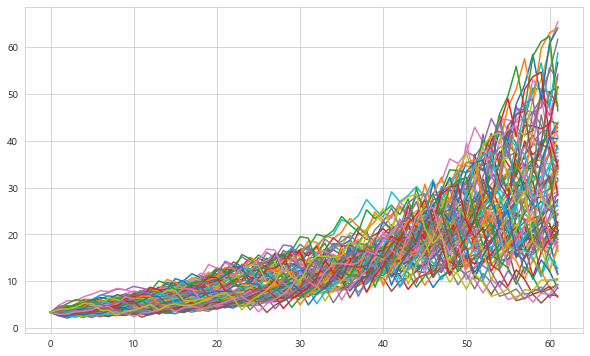

In [335]:
(df_indi['TQQQ']/1300/1e4).plot()
plt.legend().set_visible(False)